In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision.transforms.functional import pil_to_tensor
import torch.nn.functional as F
from torch.optim.adam import Adam

In [2]:
train_data = MNIST(root="./data", download=True, train=True)
val_data = MNIST(root="./data", download=True, train=False)

In [3]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1):
        super().__init__()
        self.conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

In [4]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.block1 = EncoderBlock(1, 16)
        self.block2 = EncoderBlock(16, 32)
    
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        return x
    
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.block1 = DecoderBlock(32, 16)
        self.block2 = DecoderBlock(16, 8)
        self.conv_output = nn.Conv2d(8, 1, kernel_size=3, stride=1, padding=1)
    
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.conv_output(x)
        return x
    

class VQEmbedding(nn.Module):
    def __init__(self, num_embeddings: int, embedding_dim: int, beta: float = 0.25):
        super().__init__()

        self.beta = beta

        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1/num_embeddings, 1/num_embeddings)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        b, c, h, w = x.shape
        z = x.permute(0, 2, 3, 1)
        z = torch.reshape(z, (b * h * w, c))

        distance = (
            torch.sum(z**2, dim=1, keepdim=True) + \
            torch.sum(self.embedding.weight ** 2, dim=0, keepdim=True) + \
            -2 * torch.matmul(z, self.embedding.weight)
        )

        idx = torch.argmin(distance, dim=1)
        e = self.embedding(idx)

        st_loss = F.mse_loss(e, z.detach()) + self.beta * F.mse_loss(e.detach(), z)

        # straight-through estimator
        z_q = z + (e - z).detach()

        z_q = torch.reshape(z_q, (b, h, w, c))
        z_q = torch.permute(z_q, (0, 3, 1, 2))

        return z_q, st_loss


class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.decoder = Decoder()
        self.encoder = Encoder()
        self.embeddings = VQEmbedding(num_embeddings=32, embedding_dim=32)
    
    def forward(self, x):
        h = self.encoder(x)
        z_q, st_loss = self.embeddings(h)
        output = self.decoder(z_q)
        output = F.sigmoid(output)

        return output, st_loss

In [5]:
from torch.utils.data import DataLoader, Dataset

class MNISTDataset(Dataset):
    def __init__(self, train):
        self.data = MNIST(root="./data", download=True, train=train)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        img = self.data[index][0]

        img_tensor = pil_to_tensor(img)
        img_tensor = img_tensor / 255.0

        return img_tensor

In [6]:
device = "cuda"
batch_size = 1024
lr = 1e-2
seed = 42

In [7]:
torch.manual_seed(seed)
model = Model()
model = model.to(device)

In [8]:
train_data = MNISTDataset(train=True)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4)

val_data = MNISTDataset(train=False)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4)

In [9]:
optimizer = Adam(model.parameters(), lr=lr)

In [10]:
num_epochs = 10

for epoch in range(num_epochs):
    train_epoch_loss, val_epoch_loss = 0.0, 0.0
    for imgs in train_loader:
        model.zero_grad()

        imgs = imgs.to(device)
        o, st_loss = model(imgs)

        reconstruction_loss = F.mse_loss(o, imgs)
        loss = reconstruction_loss + st_loss
        loss.backward()
        optimizer.step()

        train_epoch_loss += loss.detach().cpu().numpy()

    train_epoch_loss = round(train_epoch_loss / len(train_loader), 4)

    with torch.no_grad():
        for img in val_loader:
            imgs = imgs.to(device)
            o, st_loss = model(imgs)

            reconstruction_loss = F.mse_loss(o, imgs)
            loss = reconstruction_loss + st_loss

            val_epoch_loss += loss.detach().cpu().numpy()

    val_epoch_loss = round(val_epoch_loss / len(val_loader), 4)


    print(f"----- Epoch {epoch} -----")
    print(f"Training loss: {train_epoch_loss}")
    print(f"Val loss: {val_epoch_loss}")

----- Epoch 0 -----
Training loss: 0.4641999900341034
Val loss: 0.2847999930381775
----- Epoch 1 -----
Training loss: 0.17640000581741333
Val loss: 0.09489999711513519
----- Epoch 2 -----
Training loss: 0.07980000227689743
Val loss: 0.06040000170469284
----- Epoch 3 -----
Training loss: 0.0544000007212162
Val loss: 0.04899999871850014
----- Epoch 4 -----
Training loss: 0.04580000042915344
Val loss: 0.044199999421834946
----- Epoch 5 -----
Training loss: 0.04399999976158142
Val loss: 0.04540000110864639
----- Epoch 6 -----
Training loss: 0.04500000178813934
Val loss: 0.046300001442432404
----- Epoch 7 -----
Training loss: 0.04820000007748604
Val loss: 0.050200000405311584
----- Epoch 8 -----
Training loss: 0.052000001072883606
Val loss: 0.05420000106096268
----- Epoch 9 -----
Training loss: 0.057100001722574234
Val loss: 0.05649999901652336


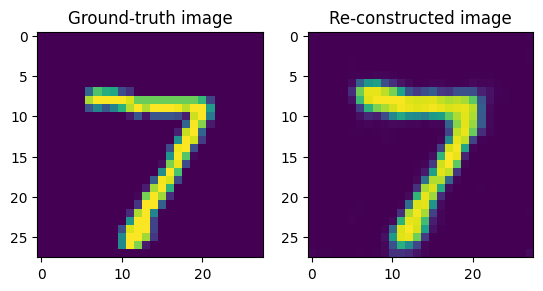

In [11]:
example = val_data[0]

gt_img = np.asarray(example* 255)[0, :, :]

input_img = example.to(device).unsqueeze(0)
o, st_loss = model(input_img)
o = o.detach().cpu()
pred_img = np.asarray(o * 255)[0, 0, :, :]

f, axarr = plt.subplots(1,2)
axarr[0].imshow(gt_img)
axarr[0].set_title("Ground-truth image")
axarr[1].imshow(pred_img)
axarr[1].set_title("Re-constructed image")

plt.show()